In [ ]:
     !pip install -qq yellowbrick category_encoders catboost

In [ ]:
# some builtin imports
import re
import warnings
from collections import Counter
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Some usual imports here
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


# sklearn models
from sklearn import metrics, model_selection

import catboost as cb

# visualizations
import shap
from yellowbrick.regressor import residuals_plot, prediction_error

In [ ]:
## Customize Matplotlib Parameters
%matplotlib inline
mpl.rcParams['figure.dpi']= 120
mpl.rcParams['figure.edgecolor']= 'black'
mpl.rcParams['axes.linewidth']= .5
# Customize Seaborn Parameters
sns.set()
rc = {
      'font.family': ['serif'],
      'font.serif':'Times New Roman',
      'grid.color': 'gainsboro',
      'grid.linestyle': '-',
}
sns.set_style(rc=rc)
sns.set_context("notebook", font_scale=0.8)

In [ ]:
from google.colab import files
import pandas as pd

# Upload the file
uploaded = files.upload()

# Assuming you have uploaded a CSV file named 'house_rental_fin.csv'
# Read the uploaded file into a DataFrame
import io
df = pd.read_csv(io.BytesIO(uploaded['house_rental_fin.csv']))

# Display the first few rows
df.head()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17890 entries, 0 to 17889
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   category_Flats                 17890 non-null  float64
 1   category_Detached              17890 non-null  float64
 2   category_Townhouse             17890 non-null  float64
 3   category_Duplex                17890 non-null  float64
 4   category_Mansion               17890 non-null  float64
 5   category_Semi-Detached         17890 non-null  float64
 6   bedrooms                       17890 non-null  float64
 7   bathrooms                      17890 non-null  float64
 8   floor_area                     17890 non-null  float64
 9   condition_Used                 17890 non-null  float64
 10  condition_New                  17890 non-null  float64
 11  condition_Renovated            17890 non-null  float64
 12  amenities_24-hour electricity  17890 non-null 

In [ ]:
def compute_metrics(model, x, y, cv=5):
    preds = model.predict(x)
    score = model.score(x, y)

    scores_cvs = model_selection.cross_val_score(model, x, y, scoring='r2', cv=cv)

    return pd.DataFrame([{
        "R2": round(score, 3),
        "mse": round(metrics.mean_squared_error(y, preds), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y, preds)), 3),
        "mae": round(metrics.mean_absolute_error(y, preds), 3),
        "adjusted_r2": round(1 - (1 - score) * (len(y) - 1) / (len(y) - x.shape[1] - 1), 3),
        "cv_score": round(scores_cvs.mean()*100, 2)
    }])

In [ ]:
# train-test split for model evaluation
X = df.drop(['price', 'log1p_price'], axis=1).values
y = df['log1p_price'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42
)

In [ ]:
X_train.shape, X_test.shape

((14312, 37), (3578, 37))

In [ ]:
model = cb.CatBoostRegressor(random_seed=42, logging_level='Silent')

model = model.fit(X_train, y_train)

In [ ]:
train_metrics = compute_metrics(model, X_train, y_train)
train_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.912,0.114,0.338,0.256,0.911,87.01


In [ ]:
val_metrics = compute_metrics(model, X_test, y_test)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.877,0.162,0.403,0.301,0.876,85.43


In [ ]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'lea

In [ ]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

grid = {
    'iterations': [100, 200, 500, 1000],
    'learning_rate': [0.03, 0.1],
    'depth': [2, 4, 6, 8],
    'l2_leaf_reg': [0.2, 0.5, 1, 3]
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor

# A small hyperparameter grid to avoid long runtimes
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [50, 100, 200]
}

# CatBoostRegressor with early stopping to prevent long training times
model = CatBoostRegressor(
    random_seed=42,
    logging_level='Silent',
    early_stopping_rounds=10
)

# Lighter RandomizedSearchCV
grid_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,         # fewer combinations
    cv=3,              # 3-fold CV to speed it up
    scoring='r2',
    verbose=2,
    n_jobs=1,          # use single core to avoid parallel issues
    refit=True
)

# Fit the model
grid_search.fit(X_train, y_train)

# Output the best parameters and R2 score
print("Best hyperparameters:", grid_search.best_params_)
print("Best R2 score:", grid_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .........depth=6, iterations=50, learning_rate=0.05; total time=   0.4s
[CV] END .........depth=6, iterations=50, learning_rate=0.05; total time=   0.4s
[CV] END .........depth=6, iterations=50, learning_rate=0.05; total time=   0.4s
[CV] END ..........depth=6, iterations=50, learning_rate=0.1; total time=   0.4s
[CV] END ..........depth=6, iterations=50, learning_rate=0.1; total time=   0.4s
[CV] END ..........depth=6, iterations=50, learning_rate=0.1; total time=   0.4s
[CV] END ........depth=4, iterations=100, learning_rate=0.05; total time=   0.4s
[CV] END ........depth=4, iterations=100, learning_rate=0.05; total time=   0.4s
[CV] END ........depth=4, iterations=100, learning_rate=0.05; total time=   0.5s
[CV] END ........depth=8, iterations=200, learning_rate=0.05; total time=   3.4s
[CV] END ........depth=8, iterations=200, learning_rate=0.05; total time=   2.1s
[CV] END ........depth=8, iterations=200, learni

In [ ]:
best_model = grid_search.best_estimator_

train_metrics = compute_metrics(best_model, X_train, y_train)
train_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.901,0.128,0.358,0.27,0.901,86.59


In [ ]:
val_metrics = compute_metrics(best_model, X_test, y_test)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.871,0.17,0.412,0.309,0.87,85.16


In [ ]:
from yellowbrick.contrib.wrapper import wrap

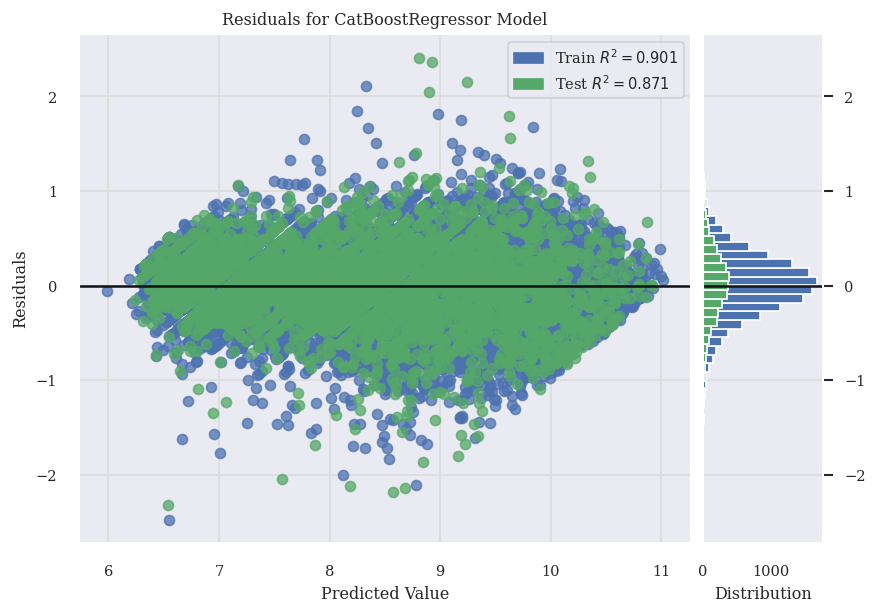

In [ ]:
visualizer = residuals_plot(
    wrap(best_model), X_train, y_train, X_test, y_test,
)

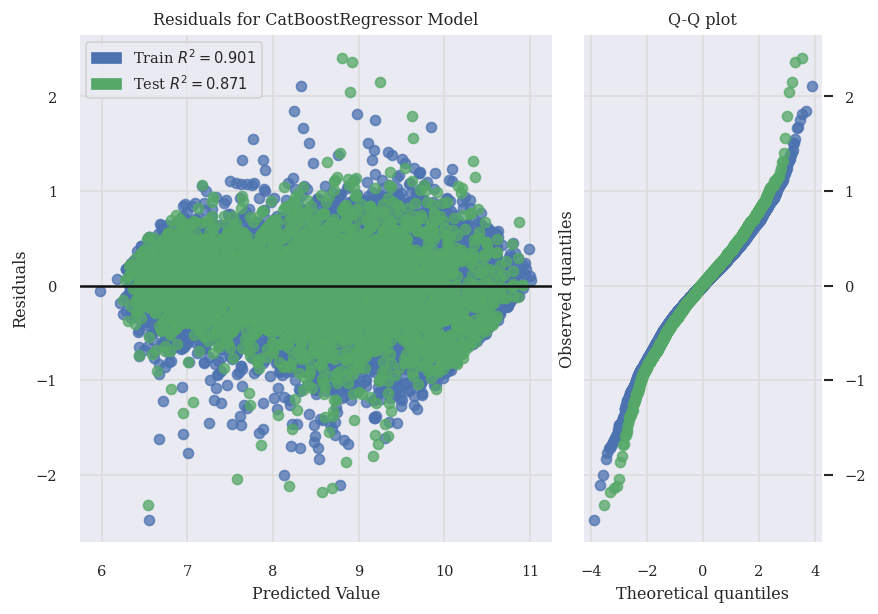

In [ ]:
visualizer = residuals_plot(
    wrap(best_model), X_train, y_train, X_test, y_test, hist=False, qqplot=True
)

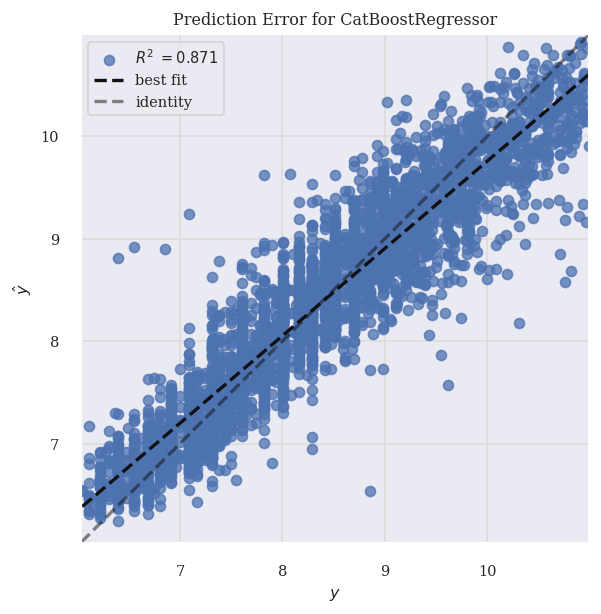

In [ ]:
visualizer = prediction_error(wrap(best_model), X_train, y_train, X_test, y_test)

In [ ]:
variables = abs(best_model.feature_importances_)
coef_df = pd.DataFrame(
    {
        "Variable": df.drop(['price', 'log1p_price'], axis=1).columns,
        "Value": variables,
    }
)
n = 10
sorted_df = (
    coef_df.sort_values(by="Value", ascending=False)
    .head(n)
    .sort_values(by="Value")
)
sorted_df

,Variable,Value
22,amenities_microwave,1.785863
25,amenities_refrigerator,2.268951
0,category_Flats,2.585951
8,floor_area,4.231086
7,bathrooms,10.199098
13,amenities_air conditioning,10.209253
36,furnishing_Furnished,10.940980
31,lat,12.292482
6,bedrooms,15.037845
32,lng,18.709103


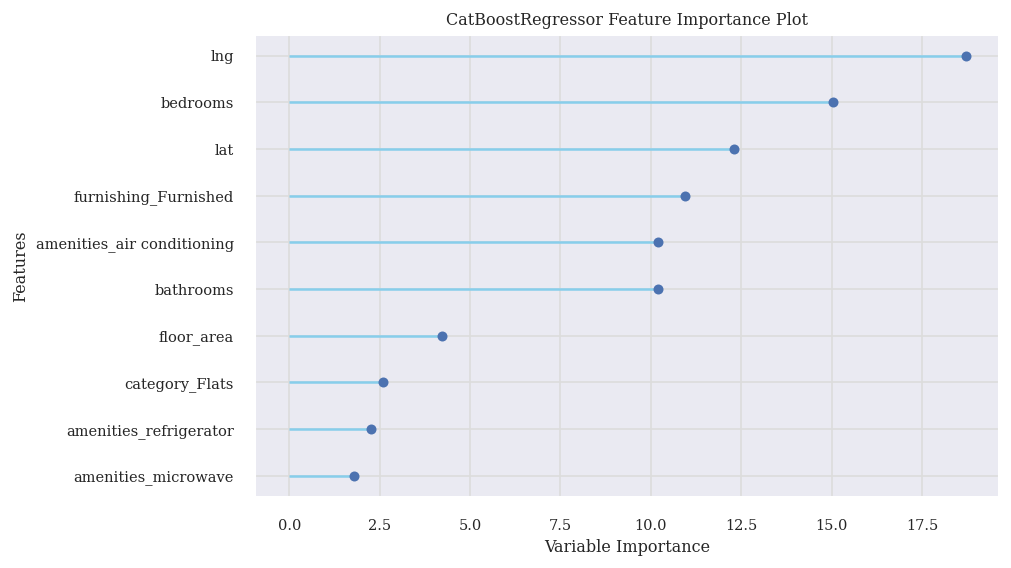

In [ ]:
my_range = range(1, len(sorted_df.index) + 1)
plt.figure(figsize=(8, 5 * (n // 10)))
plt.hlines(
    y=my_range,
    xmin=0,
    xmax=sorted_df["Value"],
    color="skyblue",
)
plt.plot(sorted_df["Value"], my_range, "o")
plt.yticks(my_range, sorted_df["Variable"])
plt.title("CatBoostRegressor Feature Importance Plot")
plt.xlabel("Variable Importance")
plt.ylabel("Features")
plt.show()

In [ ]:
explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_test)

In [ ]:
feature_names=coef_df.sort_values(by="Value", ascending=False)['Variable'].values
feature_names

array(['lng', 'bedrooms', 'lat', 'furnishing_Furnished',
       'amenities_air conditioning', 'bathrooms', 'floor_area',
       'category_Flats', 'amenities_refrigerator', 'amenities_microwave',
       'amenities_wardrobe', 'amenities_count', 'amenities_hot water',
       'condition_New', 'amenities_dishwasher',
       'amenities_24-hour electricity', 'amenities_apartment',
       'amenities_wi-fi', 'amenities_pop ceiling',
       'furnishing_Unfurnished', 'amenities_tv', 'amenities_chandelier',
       'furnishing_Semi-Furnished', 'amenities_pre-paid meter',
       'amenities_kitchen shelf', 'category_Townhouse',
       'amenities_kitchen cabinets', 'condition_Used',
       'amenities_dining area', 'amenities_tiled floor',
       'category_Detached', 'amenities_balcony', 'category_Duplex',
       'category_Semi-Detached', 'category_Mansion', 'parking_space',
       'condition_Renovated'], dtype=object)

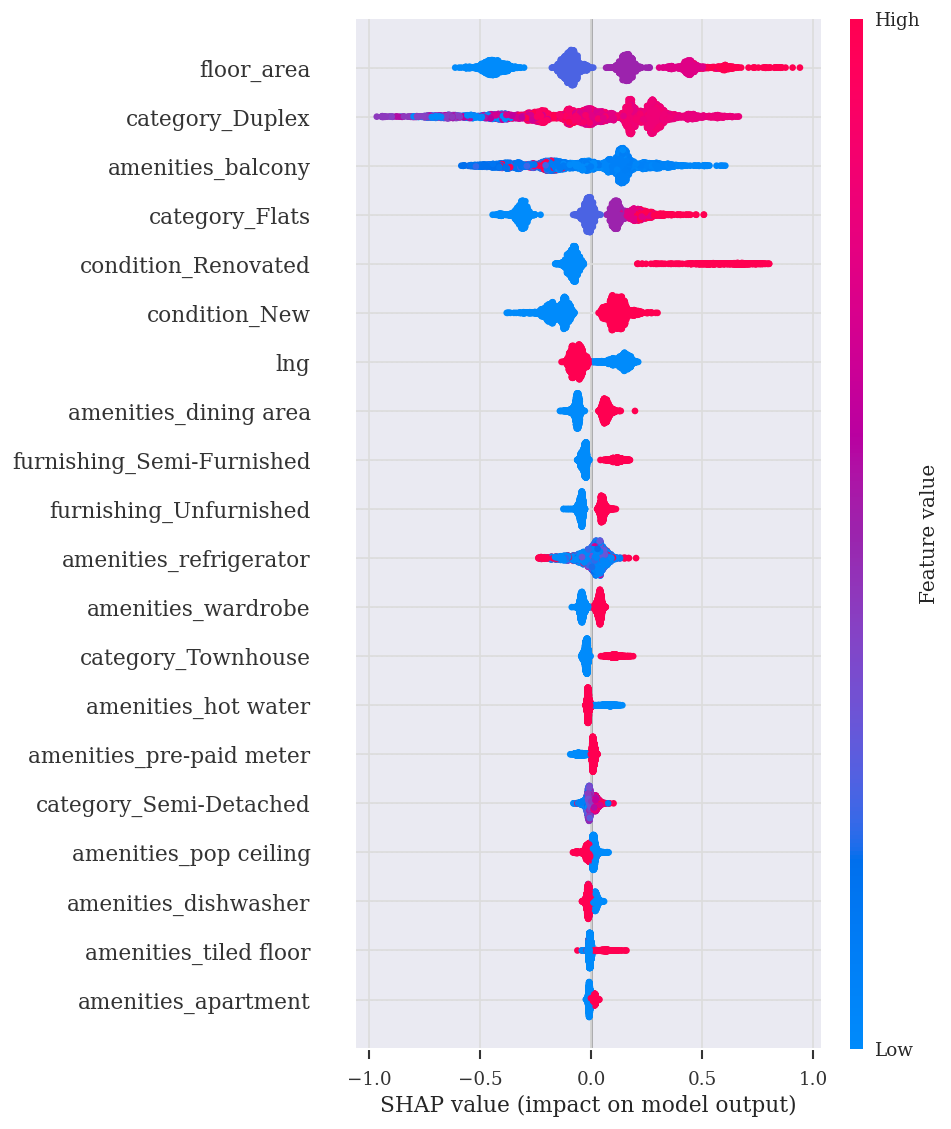

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

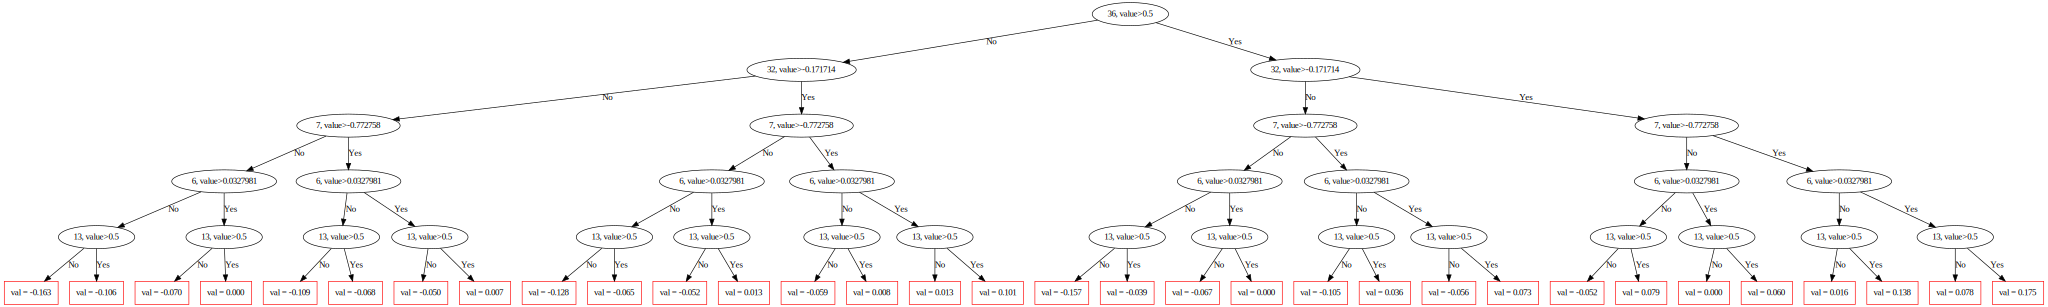

In [ ]:
best_model.plot_tree(
    tree_idx=0,
)

In [ ]:
preds = best_model.predict(X_test)

In [ ]:
# Reverse the log transformation
actual_preds = np.expm1(preds)
actual_y_test = np.expm1(y_test)

# Compute metrics on the original scale
def compute_metrics_original_scale(y_true, y_pred):
    return pd.DataFrame([{
        "R2": round(metrics.r2_score(y_true, y_pred), 3),
        "mse": round(metrics.mean_squared_error(y_true, y_pred), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 3),
        "mae": round(metrics.mean_absolute_error(y_true, y_pred), 3),
    }])

val_metrics_original_scale = compute_metrics_original_scale(actual_y_test, actual_preds)
val_metrics_original_scale

,R2,mse,rmse,mae
0,0.721,3.247818e+07,5698.963,2756.731


In [ ]:
pred_df = pd.DataFrame({"actual": actual_y_test, "pred": actual_preds})
pred_df.head(10)

,actual,pred
0,2000.0,2124.622871
1,2500.0,3306.515336
2,1500.0,956.622996
3,1000.0,1219.095581
4,4000.0,5590.801283
5,3500.0,4133.021459
6,5000.0,3397.847944
7,3000.0,4118.769027
8,8000.0,10540.578722
9,1200.0,833.651470


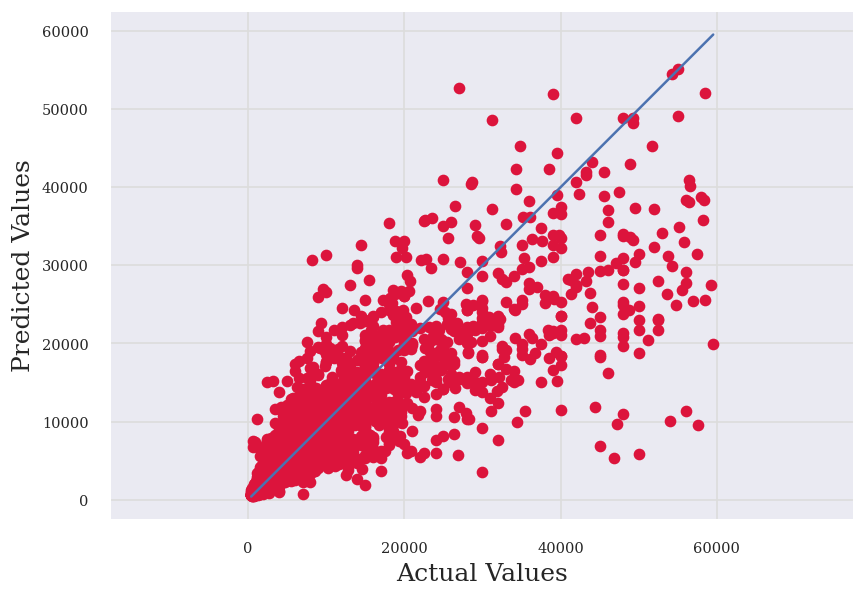

In [ ]:
plt.scatter(pred_df.actual, pred_df.pred, c='crimson')
p1 = max(max(pred_df.actual), max(pred_df.pred))
p2 = min(min(pred_df.actual), min(pred_df.pred))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.axis('equal')
plt.show()

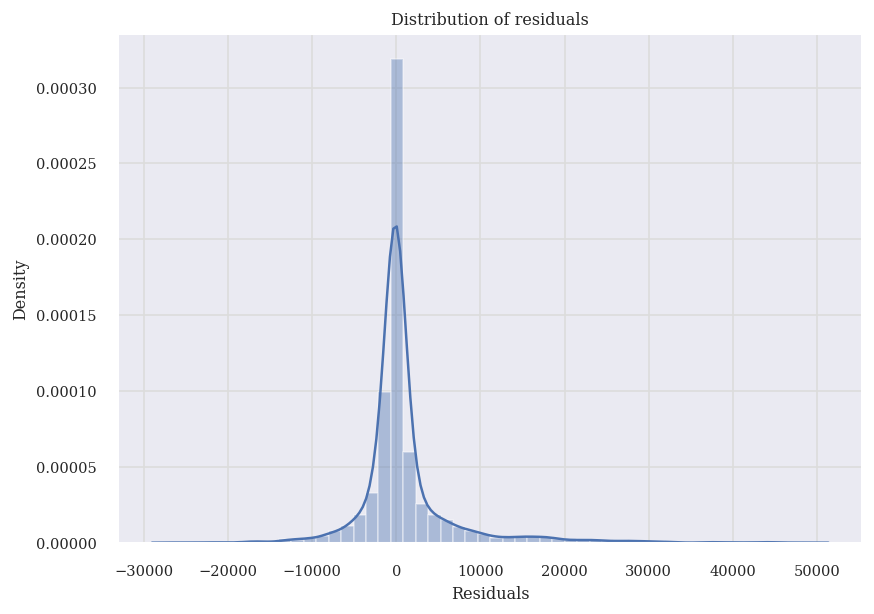

In [ ]:
sns.distplot((pred_df.actual-pred_df.pred))
plt.title('Distribution of residuals')
plt.xlabel("Residuals")
plt.show()